In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier 

# Classification

In [2]:
df = pd.read_csv("caardio_train.csv")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data Cleaning

In [3]:
df.drop("id",axis=1,inplace=True)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [6]:
df['cardio'].value_counts()

1    32769
0    32745
Name: cardio, dtype: int64

# EDA

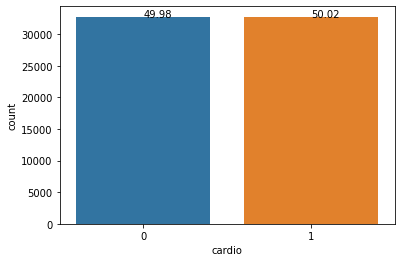

In [7]:
# Let us first have a look at our target variable.
fig, ax = plt.subplots(1,1)
sns.countplot(df['cardio'], ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}'.format((i.get_height()/len(df['cardio']))*100,'%'))
plt.show()

In [8]:
# Age is given in days. Transforming it into years for better understanding and checking relation 
# with the target variable.
df['age'] = df['age']/365

No handles with labels found to put in legend.


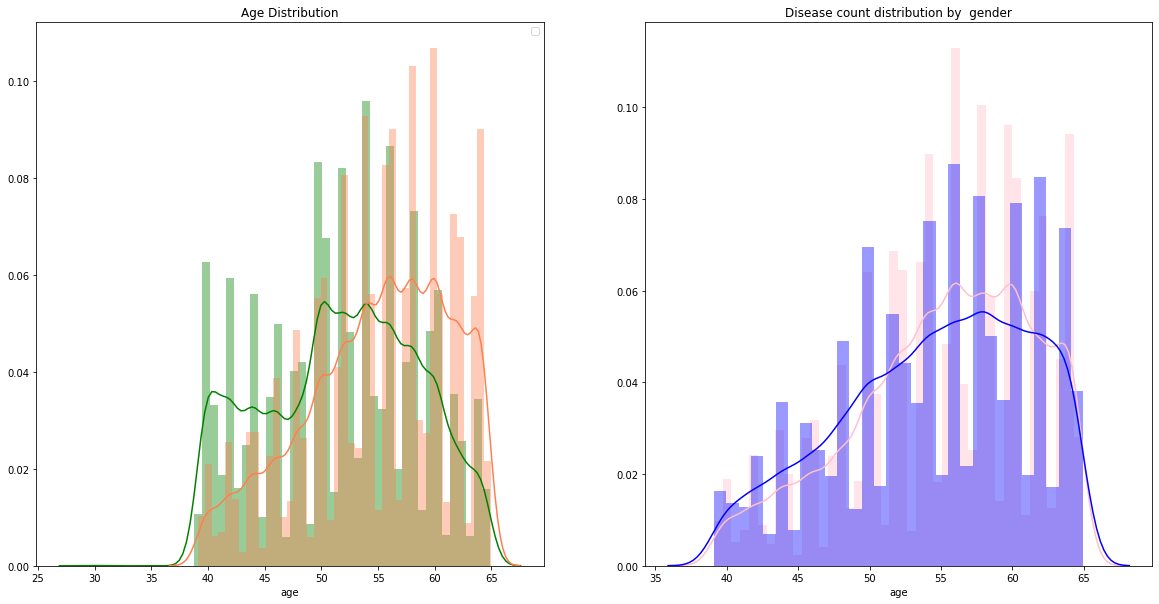

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.distplot(df['age'][df['cardio']==0], ax = ax1, color='green')
sns.distplot(df['age'][df['cardio']==1], ax = ax1,color='coral')
ax1.set_title('Age Distribution')
ax1.legend()


sns.distplot(df['age'][(df['gender']==1) & (df['cardio']==1)],ax = ax2,color='pink')
sns.distplot(df['age'][(df['gender']==2) & (df['cardio']==1)],ax = ax2,color='blue')
ax2.set_title('Disease count distribution by  gender')
plt.show()


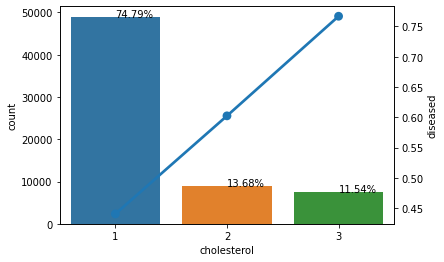

In [10]:
# cholesterol
tmp = pd.crosstab(df['cholesterol'],df['cardio'],normalize='index')
tmp.reset_index()
tmp.columns = ['not diseased','diseased']
fig, ax = plt.subplots(1,1)
sns.countplot(df['cholesterol'],order=list(tmp.index), ax=ax)
plot2 = ax.twinx()
sns.pointplot(tmp.index,tmp['diseased'],order=list(tmp.index),ax=plot2)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2,height,'{:.2f}{}'.format(height/len(df['cholesterol'])*100,'%'))
plt.show()

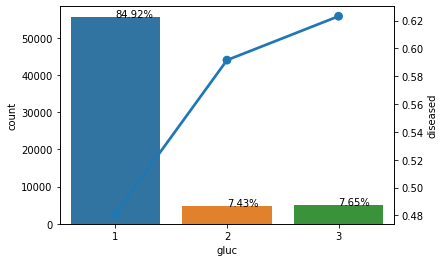

In [11]:
# Glucose
tmp = pd.crosstab(df['gluc'],df['cardio'],normalize='index')
tmp.reset_index()
tmp.columns = ['not diseased','diseased']
fig, ax = plt.subplots(1,1)
sns.countplot(df['gluc'],order=list(tmp.index), ax=ax)
plot2 = ax.twinx()
sns.pointplot(tmp.index,tmp['diseased'],order=list(tmp.index),ax=plot2)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2,height,'{:.2f}{}'.format(height/len(df['gluc'])*100,'%'))
plt.show()

# Data Preprocessing

In [12]:
# ap_hi
filt = (df['ap_hi']<90) | (df['ap_hi']>140)
print(f'Normal systolic blood pressure range is between 90 and 120. However, from our dataset we can see that we have {len(df[filt])} records that are not falling within the normal range. We can replace them with their median values.')


Normal systolic blood pressure range is between 90 and 120. However, from our dataset we can see that we have 9558 records that are not falling within the normal range. We can replace them with their median values.


In [13]:
df['ap_hi'].replace(df[filt]['ap_hi'].values,df['ap_hi'].median(),inplace=True)

In [14]:
# BMI = weight(kg)/height(m2)
df['BMI'] = df['weight']/(((df['height']/0.0328084)*.01)**2)

In [15]:
df[df['cardio']==1]['cholesterol'].value_counts()

1    21576
3     5796
2     5397
Name: cholesterol, dtype: int64

In [16]:
df[df['cardio']==0]['cholesterol'].value_counts()

1    27420
2     3563
3     1762
Name: cholesterol, dtype: int64

In [17]:
x = df.drop('cardio', axis=1)
y = df['cardio']
x["age"] = RobustScaler().fit_transform(x["age"].values.reshape(-1,1))
x["height"] = RobustScaler().fit_transform(x["height"].values.reshape(-1,1))
x["weight"] = RobustScaler().fit_transform(x["weight"].values.reshape(-1,1))
x["ap_lo"] = RobustScaler().fit_transform(x["ap_lo"].values.reshape(-1,1))
x["ap_hi"] = RobustScaler().fit_transform(x["ap_hi"].values.reshape(-1,1))
x["BMI"] = RobustScaler().fit_transform(x["ap_hi"].values.reshape(-1,1))

# Train Test Split

In [18]:
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# Model

## Logistic Regression

In [69]:
logreg = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1.7,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight={1:0.5, 0:0.5},
    random_state=31,
    solver='lbfgs',
    max_iter=10000,
    multi_class='auto',
    verbose=1,
    warm_start=True,
    n_jobs=None,
    l1_ratio=None)

logreg.fit(x_train, y_train)
ypred = logreg.predict(x_test)
accuracy_score(y_test, ypred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


0.6841944592841334

## Random Forest

In [89]:
rf = RandomForestClassifier(n_estimators=100,
    criterion='gini',
    max_depth=12,
    min_samples_split=3,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,)

rf.fit(x_train, y_train)
ypred = rf.predict(x_test)
accuracy_score(y_test, ypred)

0.7227352514691292

0.6994581393573991

## LGBM

In [24]:
lgb = LGBMClassifier(num_leaves=31, n_estimators=700, learning_rate=0.01)

In [25]:
lgb.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=700, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
y_test_pred = lgb.predict(x_test)

In [27]:
accuracy_score(y_test, y_test_pred)

0.7207509730596047

In [28]:
y_train_pred = lgb.predict(x_train)
accuracy_score(y_train, y_train_pred)

0.7341397798172139

## out of the box

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

/home/deepak/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/deepak/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/deepak/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/deepak/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [89]:
# x_train['f_lgbm'] = y_train_pred
# x_test['f_lgbm'] = y_test_pred

In [90]:
# #Normalizing the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [91]:
# x_train = sc.transform(x_train)
# x_test = sc.transform(x_test)

In [92]:
print(x_train.shape)
print(x_test.shape)

(52411, 12)
(13103, 12)


In [182]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(12, input_shape=(12,)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer='l2'))
# model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000,
                                                          decay_rate=0.9)
opt = tf.keras.optimizers.Adam()#learning_rate=lr_schedule)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Accuracy()])

In [191]:
model.fit(x_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
52411/52411 [==============================] - 2s 43us/sample - loss: 0.5677 - accuracy: 0.0000e+00
Epoch 2/100
52411/52411 [==============================] - 2s 41us/sample - loss: 0.5674 - accuracy: 0.0000e+00
Epoch 3/100
52411/52411 [==============================] - 2s 41us/sample - loss: 0.5671 - accuracy: 0.0000e+00
Epoch 4/100
52411/52411 [==============================] - 2s 41us/sample - loss: 0.5677 - accuracy: 0.0000e+00
Epoch 5/100
52411/52411 [==============================] - 2s 41us/sample - loss: 0.5687 - accuracy: 0.0000e+00
Epoch 6/100
52411/52411 [==============================] - 2s 43us/sample - loss: 0.5684 - accuracy: 0.0000e+00
Epoch 7/100
52411/52411 [==============================] - 2s 39us/sample - loss: 0.5684 - accuracy: 0.0000e+00
Epoch 8/100
52411/52411 [==============================] - 2s 32us/sample - loss: 0.5682 - accuracy: 0.0000e+00
Epoch 9/100
52411/52411 [==============================] - 2s 32us/sample - loss: 0.5681 - accuracy: 0.0

In [192]:
y_pred = model.predict(x_test)

In [193]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [194]:
accuracy_score(y_test, y_pred)

0.7132717698237045